In [227]:
#Selenium 4.9.0
from selenium import webdriver
from selenium.webdriver.edge.service import Service
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from msedge.selenium_tools import Edge, EdgeOptions

import re
import time
from datetime import datetime
import pandas as pd

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import plotly.express as px
import matplotlib.pyplot as plt

In [228]:
game_id = 1245620
url_template = "https://steamcommunity.com/app/{}/reviews/?p=1&browsefilter=mostrecent&filterLanguage=english"
url = url_template.format(game_id)
print(url)

https://steamcommunity.com/app/1245620/reviews/?p=1&browsefilter=mostrecent&filterLanguage=english


In [229]:
service = Service()
options = webdriver.EdgeOptions()

language = "en-US"
options.add_argument(f"--lang={language}")

driver = webdriver.Edge(service=service, options=options)
driver.maximize_window()
driver.get(url)


In [230]:
#driver.quit()

In [231]:
def get_current_scroll_position(driver):
    return driver.execute_script("return window.pageYOffset;")

def scroll_to_bottom(driver):
    driver.execute_script("window.scrollTo(20, document.body.scrollHeight);")
    time.sleep(1)

def get_steam_id(card):
    profile_url = card.find_element(By.XPATH, './/div[@class="apphub_friend_block"]/div/a[2]').get_attribute('href')
    steam_id = profile_url.split('/')[-2]
    return steam_id
def scrape_review_data(card):
    date_posted_element = card.find_element(By.XPATH, './/div[@class="apphub_CardTextContent"]/div[@class="date_posted"]')
    date_posted = date_posted_element.text.strip()

    card_text_content_element = card.find_element(By.CLASS_NAME, "apphub_CardTextContent")
    review_content = card_text_content_element.text.strip()
    excluded_elements = [date_posted]

    for excluded_element in excluded_elements:
        review_content = review_content.replace(excluded_element, "")
    review_content = review_content.replace("\n", "")

    review_length = len(review_content.replace(" ", ""))

    thumb_text = card.find_element(By.XPATH, './/div[@class="reviewInfo"]/div[2]').text
    play_hours = card.find_element(By.XPATH, './/div[@class="reviewInfo"]/div[3]').text

    return review_content, thumb_text, review_length, play_hours, date_posted
    

In [232]:
reviews = []
steam_ids_set = set()
max_scroll_attempts = 5

try:
    last_position = get_current_scroll_position(driver)
    running = True
    while running:
        cards = driver.find_elements(By.CLASS_NAME, 'apphub_Card')

        for card in cards[-20:]:
            steam_id = get_steam_id(card)
            if steam_id in steam_ids_set:
                continue
            else:
                review = scrape_review_data(card)
                reviews.append(review)

        scroll_attempt= 0
        while scroll_attempt < max_scroll_attempts:
            scroll_to_bottom(driver)
            curr_position = get_current_scroll_position(driver)

            if curr_position == last_position:
                scroll_attempt += 1
                time.sleep(3)

                if curr_position >= 3:
                    running = False
                    break
            else:
                last_position = curr_position
                break
        
    
except Exception as e:
    print(e)

finally:
    driver.quit()

In [354]:
df = pd.DataFrame(reviews, columns= ['ReviewText', 'Review', 'ReviewLength', 'PlayHours', 'DatePosted'])

In [355]:
df.head()

,ReviewText,Review,ReviewLength,PlayHours,DatePosted
0,"Not my cup of tea, I preferred other FromSoftw...",Recommended,113,256.4 hrs on record,Posted: March 29
1,Best game I have ever played.,Recommended,24,118.7 hrs on record,Posted: March 29
2,ya,Recommended,2,96.2 hrs on record,Posted: March 29
3,yes,Recommended,3,30.4 hrs on record,Posted: March 29
4,millions of poor defenseless albinaurics i kil...,Recommended,89,238.7 hrs on record,Posted: March 29


In [356]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ReviewText    930 non-null    object
 1   Review        930 non-null    object
 2   ReviewLength  930 non-null    int64 
 3   PlayHours     930 non-null    object
 4   DatePosted    930 non-null    object
dtypes: int64(1), object(4)
memory usage: 36.5+ KB


In [357]:
df.shape

(930, 5)

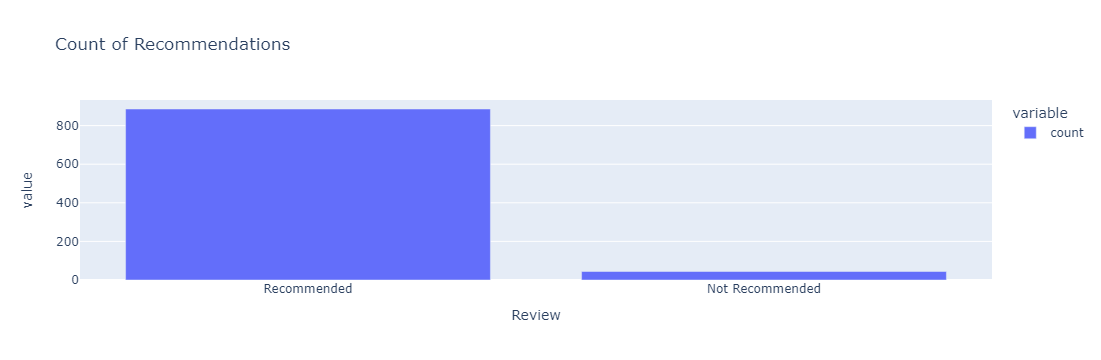

In [358]:
px.bar(df['Review'].value_counts(), title='Count of Recommendations')

In [359]:
df['PlayHours'] = df['PlayHours'].map(lambda x: re.sub(' hrs on record', '', x))
df['PlayHours'] = df['PlayHours'].map(lambda x: re.sub(',', '', x)).astype(float)

In [360]:
df.head()

,ReviewText,Review,ReviewLength,PlayHours,DatePosted
0,"Not my cup of tea, I preferred other FromSoftw...",Recommended,113,256.4,Posted: March 29
1,Best game I have ever played.,Recommended,24,118.7,Posted: March 29
2,ya,Recommended,2,96.2,Posted: March 29
3,yes,Recommended,3,30.4,Posted: March 29
4,millions of poor defenseless albinaurics i kil...,Recommended,89,238.7,Posted: March 29


In [361]:
df['DatePosted'] = df['DatePosted'].map(lambda x: re.sub('Posted: ', '', x))

In [372]:
df.head()

In [363]:
month_mapping = {
    'January': '01',
    'February': '02',
    'March': '03',
    'April': '04',
    'May': '05',
    'June': '06',
    'July': '07',
    'August': '08',
    'September': '09',
    'October': '10',
    'November': '11',
    'December': '12'
}

In [364]:
df[['Month', 'Day']] = df['DatePosted'].str.extract(r'(\w+) (\d+)', expand=True)

In [365]:
df.head()

,ReviewText,Review,ReviewLength,PlayHours,DatePosted,Month,Day
0,"Not my cup of tea, I preferred other FromSoftw...",Recommended,113,256.4,March 29,March,29
1,Best game I have ever played.,Recommended,24,118.7,March 29,March,29
2,ya,Recommended,2,96.2,March 29,March,29
3,yes,Recommended,3,30.4,March 29,March,29
4,millions of poor defenseless albinaurics i kil...,Recommended,89,238.7,March 29,March,29


In [366]:
df['Month'] = df['Month'].map(month_mapping)

In [367]:
df.head()

,ReviewText,Review,ReviewLength,PlayHours,DatePosted,Month,Day
0,"Not my cup of tea, I preferred other FromSoftw...",Recommended,113,256.4,March 29,03,29
1,Best game I have ever played.,Recommended,24,118.7,March 29,03,29
2,ya,Recommended,2,96.2,March 29,03,29
3,yes,Recommended,3,30.4,March 29,03,29
4,millions of poor defenseless albinaurics i kil...,Recommended,89,238.7,March 29,03,29


In [368]:
df['DatePosted'] = df['Month'] + '/' + df['Day'] + '/2024'
df['DatePosted'] = pd.to_datetime(df['DatePosted'], format='%m/%d/%Y').dt.strftime('%m-%d-%Y')
df = df.drop(['Month', 'Day'], axis=1)

In [369]:
df.head()

,ReviewText,Review,ReviewLength,PlayHours,DatePosted
0,"Not my cup of tea, I preferred other FromSoftw...",Recommended,113,256.4,03-29-2024
1,Best game I have ever played.,Recommended,24,118.7,03-29-2024
2,ya,Recommended,2,96.2,03-29-2024
3,yes,Recommended,3,30.4,03-29-2024
4,millions of poor defenseless albinaurics i kil...,Recommended,89,238.7,03-29-2024


In [371]:
df.to_csv('game_reviews.csv', encoding='utf-8', sep=';', index=False)